<a href="https://colab.research.google.com/github/KamonohashiPerry/PyTorch/blob/master/PyTorch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorchのインストール

In [0]:
# pip install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl

In [0]:
# pip install torchvision

In [0]:
# pip install tqdm

インストールできたかの確認

In [0]:
# import torch

In [0]:
# torch.tensor([1, 2, 3]).to("cuda:0")

In [131]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL

vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
··········


In [132]:
# drive mean root directory of  google drive
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive/"Colab Notebooks"/PyTorch

FashionMNIST  PyTorch_2.ipynb  PyTorch.ipynb


# Chapter4

In [0]:
import torch
from torch import nn, optim
from torch.utils.data import (Dataset, DataLoader, TensorDataset)
import tqdm

## データの作成

In [2]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# 訓練用のデータを取得
# そのままだとPython Imaging Libraryの画像形式でDatasetを作ってしまうので、transforms.ToTensorでTensorに変換する
fashion_mnist_train = FashionMNIST("drive/Colab Notebooks/PyTorch/FashionMNIST",
                                   train=True,
                                   download=True,
                                   transform=transforms.ToTensor())

# 検証用データの取得
fashion_mnist_test = FashionMNIST("drive/Colab Notebooks/PyTorch/FashionMNIST",
                                  train=False,
                                  download=True,
                                  transform=transforms.ToTensor())

# バッチサイズが128のDataLoaderをそれぞれ作成
batch_size = 128
train_loader = DataLoader(fashion_mnist_train,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(fashion_mnist_test,
                          batch_size=batch_size,
                          shuffle=True)

0it [00:00, ?it/s]

26427392it [00:04, 5795878.96it/s]                              


Extracting drive/Colab Notebooks/PyTorch/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to drive/Colab Notebooks/PyTorch/FashionMNIST/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 36419.07it/s]                           
0it [00:00, ?it/s]

Extracting drive/Colab Notebooks/PyTorch/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to drive/Colab Notebooks/PyTorch/FashionMNIST/FashionMNIST/raw


4423680it [00:02, 1675200.29it/s]                            
0it [00:00, ?it/s]

Extracting drive/Colab Notebooks/PyTorch/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to drive/Colab Notebooks/PyTorch/FashionMNIST/FashionMNIST/raw


8192it [00:00, 15081.43it/s]            

Extracting drive/Colab Notebooks/PyTorch/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to drive/Colab Notebooks/PyTorch/FashionMNIST/FashionMNIST/raw
Processing...
Done!


## CNNの構築と学習

In [3]:
# (N, C, H, W)形式のTensorを(N, C*H*Wに引き伸ばす層)
# C:color, H:height, W:width
# 畳み込み層の出力をMLPに渡す際に必要
class FlattenLayer(nn.Module):
  def forward(self, x):
    sizes = x.size()
    return x.view(sizes[0], -1)

# 5×5のカーネルを使用し、最初に32個、次に64個のチャンネルを作成する
# BatchNorm2dは画像形式用のBatch Normalization
# Dropout2dは画像形式用のDropout
# 最後にFlattenLayerを挟む
conv_net = nn.Sequential(
    nn.Conv2d(1, 32, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.25),
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.25),
    FlattenLayer()
)

# 畳み込みによって最終的にどうようなサイズになっているかを実際にダミーデータを入れてみて確認する
test_input = torch.ones(1, 1, 28, 28)
conv_output_size = conv_net(test_input).size()[-1]
conv_output_size

1024

In [4]:
# 2層のMLP
mlp = nn.Sequential(
    nn.Linear(conv_output_size, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 10)
)

# 最終的なCNN
net = nn.Sequential(
    conv_net,
    mlp
)

net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): FlattenLayer()
  )
  (1): Sequential(
    (0): Linear(in_features=1024, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [0]:
# 評価のヘルパー関数
def eval_net(net, data_loader, device="cpu"):
  # DropoutやBatchNormを無効化
  net.eval()

  ys = []
  ypreds = []

  for x, y in data_loader:
    # toメソッドで計算を実行するデバイスに転送する
    x = x.to(device)
    y = y.to(device)

    # 確率が最大のクラスを予測
    # ここではforwardの計算だけなので自動微分に必要な処理はoffにして余計な計算を省く
    with torch.no_grad():
      _, y_pred = net(x).max(1)

    ys.append(y)
    ypreds.append(y_pred)

    # ミニバッチごとの予測結果などを1つにまとめる
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)

    # 予測精度を計算
    acc = (ys == ypreds).float().sum()/len(ys)
    return acc.item()

# 訓練のヘルパー関数
def train_net(net, train_loader, test_loader,
              optimizer_cls=optim.Adam,
              loss_fn=nn.CrossEntropyLoss(),
              n_iter=10,device="cpu"):
  train_losses = []
  train_acc = []
  val_acc = []
  optimizer = optimizer_cls(net.parameters())

  for epoch in range(n_iter):
    running_loss = 0.0
    # ネットワークを訓練モードにする
    net.train()
    n = 0
    n_acc = 0
    # 非常に時間がかかるのでtqdmを使用してプログレスバーを出す
    for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader),
                                  total = len(train_loader)):
      xx = xx.to(device)
      yy = yy.to(device)

      h = net(xx)
      loss = loss_fn(h, yy)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      n += len(xx)
      _, y_pred = h.max(1)
      n_acc += (yy == y_pred).float().sum().item()
    train_losses.append(running_loss / i)

    # 訓練データの予測精度
    train_acc.append(n_acc / n)

    # 検証データの予測精度
    val_acc.append(eval_net(net, test_loader, device))

    # このepochでの結果の表示
    print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)


In [0]:
# ネットワークの全パラメータをGPUに転送
net.to("cuda:0")

# 訓練を実行
train_net(net, train_loader, test_loader, n_iter=20,device="cuda:0")

## 転移学習

In [12]:
!wget https://github.com/lucidfrontier45/PyTorch-Book/raw/master/data/taco_and_burrito.tar.gz

--2019-12-01 06:37:08--  https://github.com/lucidfrontier45/PyTorch-Book/raw/master/data/taco_and_burrito.tar.gz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lucidfrontier45/PyTorch-Book/master/data/taco_and_burrito.tar.gz [following]
--2019-12-01 06:37:09--  https://raw.githubusercontent.com/lucidfrontier45/PyTorch-Book/master/data/taco_and_burrito.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15292798 (15M) [application/octet-stream]
Saving to: ‘taco_and_burrito.tar.gz’

taco_and_burrito.ta 100%[===================>]  14.58M  96.1MB/s    in 0.2s    

2019-12-01 06:37:11 (96.1 MB/s) - ‘t

In [0]:
# !tar -zxvf taco_and_burrito.tar.gz

In [0]:
# !mv taco_and_burrito drive/"Colab Notebooks"/PyTorch/taco_and_burrito

In [0]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [0]:
# ImageFolder関数を使用してDatasetを作成する
train_imgs = ImageFolder(
    "drive/Colab Notebooks/PyTorch/taco_and_burrito/train",
    transform = transforms.Compose([transforms.RandomCrop(224),
                                        transforms.ToTensor()])
)

test_imgs = ImageFolder(
    "drive/Colab Notebooks/PyTorch/taco_and_burrito/test",
    transform = transforms.Compose([transforms.CenterCrop(224),
                                       transforms.ToTensor()])
)

# DataLoaderを作成
train_loader = DataLoader(train_imgs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_imgs, batch_size=32, shuffle=False) # テストの方はシャッフルしない。

In [17]:
print(train_imgs.classes)

['burrito', 'taco']


In [18]:
print(train_imgs.class_to_idx)

{'burrito': 0, 'taco': 1}


In [19]:
from torchvision import models

# 事前学習済みのresnet18をロード
net = models.resnet18(pretrained=True)

# 全てのパラメータを自動微分対象外にする
for p in net.parameters():
  p.requires_grad=False

# 最後の線形層を付け替える
fc_input_dim = net.fc.in_features
net.fc = nn.Linear(fc_input_dim, 2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


In [0]:
# モデルの訓練関数

def eval_net(net, data_loader, device="cpu"):
  # DropoutやBatcNormを無効化
  net.eval()

  ys = []
  ypreds = []

  for x, y in data_loader:
    # toメソッドで計算を実行するデバイスに転送する
    x = x.to(device)
    y = y.to(device)

    # 確率が最大のクラスを予測
    # ここではforwardの計算だけなので自動微分に必要な処理はoffにして余計な計算を省く
    with torch.no_grad():
      _, y_pred = net(x).max(1)

    ys.append(y)
    ypreds.append(y_pred)

  # ミニバッチごとの予測結果などを1つにまとめる
  ys = torch.cat(ys)
  ypreds = torch.cat(ypreds)

  # 予測精度を計算
  acc = (ys == ypreds).float().sum() / len(ys)
  return acc.item()


def train_net(net, train_loader, test_loader,
              only_fc = True,
              optimizer_cls=optim.Adam,
              loss_fn=nn.CrossEntropyLoss(),
              n_iter=10,
              device="cpu"):
  train_losses = []
  train_acc = []
  val_acc = []
  if only_fc:
    # 最後の線形層のパラメータのみをoptimizerに渡す
    optimizer = optimizer_cls(net.fc.parameters())
  else:
    optimizer = optimizer_cls(net.parameters())

  for epoch in range(n_iter):
    running_loss = 0.0
    # ネットワークを訓練モードにする
    net.train()
    n = 0
    n_acc = 0

    # 非常に時間がかかるのでtqdmを使用してプログレスバーを出す
    for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader),
                                 total=len(train_loader)):
      xx = xx.to(device)
      yy = yy.to(device)

      h = net(xx)
      loss = loss_fn(h, yy)

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()
      running_loss += loss.item()

      n += len(xx)
      _, y_pred = h.max(1)
      n_acc += (yy == y_pred).float().sum().item()

    train_losses.append(running_loss / i)

    # 訓練データの予測精度
    train_acc.append(n_acc / n)

    # 検証データの予測精度
    val_acc.append(eval_net(net, test_loader, device))

    # このepochでの結果を表示
    print(epoch, train_losses[-1], train_acc[-1],
          val_acc[-1], flush=True)

In [0]:
# ネットワークの全パラメータをGPUに転送
net.to("cuda:0")

# 訓練を実行
train_net(net, train_loader, test_loader, n_iter=20, device="cuda:0")

In [0]:
# fine tuningの別の書き方

class IdentityLayer(nn.Module):
  def forward(self, x):
    return x
  
net = models.resnet18(pretrained=True)
for p in net.parameters():
  p.requires_grad=False
net.fc = IdentityLayer()

In [24]:
# 転移学習を使わない場合どうなるか

conv_net = nn.Sequential(
    nn.Conv2d(3, 32, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    FlattenLayer()
)

# 畳み込みによってどのようなサイズになっているかを実際にデータを入れて確認する
test_input = torch.ones(1, 3, 224, 224)
conv_output_size = conv_net(test_input).size()[-1]
conv_output_size

73728

In [0]:
# 最終的なCNN
net = nn.Sequential(
    conv_net,
    nn.Linear(conv_output_size, 2)
)

# 訓練を実行
train_net(net, train_loader, test_loader, n_iter=10,only_fc=False)

## CNN回帰モデルによる画像の高解像度化

In [26]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz

--2019-12-01 07:34:09--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz’

lfw-deepfunneled.tg 100%[===================>] 103.72M  14.4MB/s    in 11s     

2019-12-01 07:34:21 (9.18 MB/s) - ‘lfw-deepfunneled.tgz’ saved [108761145/108761145]



In [0]:
# !tar xf lfw-deepfunneled.tgz

In [0]:
# !mkdir lfw-deepfunneled/train

In [0]:
# mv lfw-deepfunneled/[A-W]* lfw-deepfunneled/train

In [0]:
# !mkdir lfw-deepfunneled/test

In [0]:
# mv lfw-deepfunneled/[X-Z]* lfw-deepfunneled/test

In [0]:
# pwd

In [0]:
# cd /content/lfw-deepfunneled/

In [0]:
# cd /content

In [0]:
# ls

In [0]:
class DownSizePairImageFolder(ImageFolder):
  def __init__(self, root, transform=None,
               large_size=128, small_size=32,
               **kwds):
    super().__init__(root, transform=transform, **kwds)
    self.large_resizer = transforms.Resize(large_size)
    self.small_resizer = transforms.Resize(small_size)

  def __getitem__(self, index):
    path, _ = self.imgs[index]
    img = self.loader(path)

    # 読み取った画像を128×128ピクセルと32×32ピクセルにリサイズする
    large_img = self.large_resizer(img)
    small_img = self.small_resizer(img)

    # その他の変換を適用する
    if self.transform is not None:
      large_img = self.transform(large_img)
      small_img = self.transform(small_img)

      # 32ピクセルの画像と128ピクセルの画像を返す
      return small_img, large_img
  

In [0]:
train_data = DownSizePairImageFolder(
    "/content/lfw-deepfunneled/train",
    transform=transforms.ToTensor()
)

test_data =DownSizePairImageFolder(
    "/content/lfw-deepfunneled/test",
    transform=transforms.ToTensor()
)

batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=4)

In [0]:
# モデルの作成

net = nn.Sequential(
    nn.Conv2d(3, 256, 4,
              stride=2,
              padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 4,
              stride=2,
              padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.ConvTranspose2d(512, 256, 4,
                       stride=2,
                       padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.ConvTranspose2d(256, 128, 4,
                       stride=2,
                       padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, 4,
                       stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 3, 4,
                       stride=2,
                       padding=1)
)

In [0]:
# PSNRの計算
# ピーク信号対雑音比 は画質の再現性に影響を与える、信号が取りうる最大のパワーと劣化をもたらすノイズの比率を表す工学用語で、しばしばPSNR と略される。

import math

def psnr(mse, max_v=1.0):
  return 10*math.log10(max_v**2 / mse)


# 評価のヘルパー関数
def eval_net(net, data_loader, device="cpu"):
  # DropoutやBatchNormを無効化
  net.eval()
  ys = []
  ypreds = []
  for x, y in data_loader:
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
      y_pred = net(x)
    ys.append(y)
    ypreds.append(y_pred)

    # ミニバッチごとの予測結果などを1つにまとめる
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)

    # 予測精度(MSE)を計算
    score = nn.functional.mse_loss(ypreds, ys).item()
    return score

# 訓練のヘルパー関数
def train_net(net, train_loader, test_loader,
              optimizer_cls=optim.Adam,
              loss_fn=nn.MSELoss(),
              n_iter=10,
              device="cpu"):
  train_losses = []
  train_acc = []
  val_acc = []
  optimizer = optimizer_cls(net.parameters())
  for epoch in range(n_iter):
    running_loss = 0.0
    # ネットワークを訓練モードにする
    net.train()

    n = 0
    score = 0
    # 非常に時間がかかるのでtqdmを使用してプログレスバーを出す
    for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader),
                                 total=len(train_loader)):
      xx = xx.to(device)
      yy = yy.to(device)

      y_pred = net(xx)
      loss = loss_fn(y_pred, yy)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      n += len(xx)
    train_losses.append(running_loss / len(train_loader))

    # 検証データの予測精度
    val_acc.append(eval_net(net, test_loader, device))

    # このepochでの結果を表示
    print(epoch, train_losses[-1],
          psnr(train_losses[-1]), 
          psnr(val_acc[-1]), flush=True)

In [0]:
net.to("cuda:0")
train_net(net, train_loader, test_loader, device="cuda:0")

In [0]:
# 画像を拡大してオリジナルと比較する

from torchvision.utils import save_image

In [126]:

# テストのデータセットからランダムに4つずつ取り出すDataLoader
random_test_loader = DataLoader(test_data,
                                    batch_size=4,
                                    shuffle=True)

# DataLoaderをPythonのイテレータに変換し、4つ例を取り出す
it = iter(random_test_loader)
x, y = next(it)

# Bilinearで拡大
bl_recon = torch.nn.functional.upsample(x, 128, mode="bilinear", align_corners=True)

# CNNで拡大
yp = net(x.to("cuda:0")).to("cpu")

# torch.catでオリジナル,Bilinear, CNNの画像を結合しsave_imageで画像ファイルに書き出し
save_image(torch.cat([y, bl_recon, yp], 0), "cnn_upscale.jpg",nrow=4)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


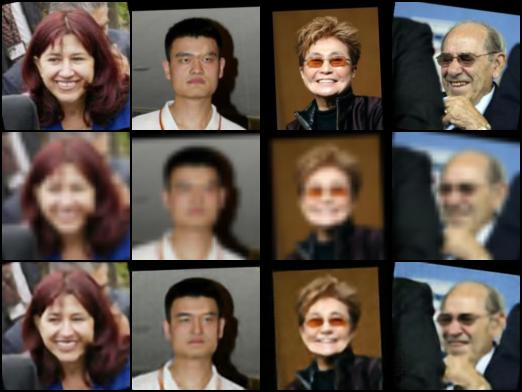

In [127]:
from IPython.display import Image, display_jpeg
display_jpeg(Image('cnn_upscale.jpg'))

## DCGANによる画像生成
### GANとは
+ 潜在ベクトルzを乱数により生成し、生成モデルによって偽のデータを生成
+ 偽のデータを識別モデルで判別する
+ 実際のデータを用意して、識別モデルで判別する
+ 偽のデータに対して判別したデータについて、それを正例としてクロスエントロピーを計算する
+ 実際のデータのサンプルのラベルが正例、偽のデータのラベルを負例としてクロスエントロピーを計算し、パラメータを更新する
+ 潜在ベクトルの生成まで戻り繰り返す

交互に、うまく騙せるように、うまく見破れるようにパラメータを更新していくのを目指すイメージらしい。

In [3]:
ls

sample_data/


In [4]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

--2019-12-01 22:47:35--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  10.3MB/s    in 34s     

2019-12-01 22:48:10 (9.64 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



In [0]:
!tar xf 102flowers.tgz

In [6]:
ls

102flowers.tgz  jpg/  sample_data/


In [0]:
!mkdir oxford-102

In [0]:
!mkdir oxford-102/jpg

In [0]:
!mv jpg/*.jpg oxford-102/jpg

In [10]:
ls

102flowers.tgz  jpg/  oxford-102/  sample_data/


In [0]:
# DataLoaderの準備
img_data = ImageFolder(
    "/content/oxford-102/",
    transform = transforms.Compose([
                                    transforms.Resize(80),
                                    transforms.CenterCrop(64),
                                    transforms.ToTensor()
    ])
)

batch_size = 64
img_loader = DataLoader(img_data,
                          batch_size=batch_size,
                          shuffle=True)

In [0]:
# 潜在特徴ベクトルｚを100次元にする
nz = 100
ngf = 32

class GNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(nz, ngf*8,
                             4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(ngf*8, ngf*4,
                           4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(ngf*4, ngf*2,
                           4, 2, 1,bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(ngf*2, ngf,
                             4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(ngf, 3,
                             4, 2, 1, bias=False),
        nn.Tanh()                                
    )

  def forward(self, x):
    out = self.main(x)
    return out

In [0]:
# class GNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.main = nn.Sequential(
#             nn.ConvTranspose2d(nz, ngf * 8, 
#                                4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(ngf * 8, ngf * 4,
#                                4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(ngf * 4, ngf * 2,
#                                4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(ngf * 2, ngf,
#                                4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(ngf, 3,
#                                4, 2, 1, bias=False),
#             nn.Tanh()
#         )

#     def forward(self, x):
#         out = self.main(x)
#         return out

In [0]:
# 識別モデルの作成
ndf = 32

class DNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf*4, ndf*8,4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
    )
  
  def forward(self, x):
    out = self.main(x)
    return out.squeeze()

In [0]:
# 訓練関数の作成
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

# Adamのパラメータは元論文の提案値
opt_d = optim.Adam(d.parameters(), lr=0.0002, betas=(0.5, 0.999))

opt_g = optim.Adam(g.parameters(), lr=0.0002, betas=(0.5, 0.999))

# クロスエントロピーを計算するための補助関数など
ones = torch.ones(batch_size).to("cuda:0")
zeros = torch.zeros(batch_size).to("cuda:0")
loss_f = nn.BCEWithLogitsLoss()

# モニタリング用のz
fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda:0")

In [0]:
# 訓練関数

from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader):
  # 生成モデル、識別モデルの目的関数の追跡用の配列
  log_loss_g = []
  log_loss_d = []
  for real_img, _ in tqdm.tqdm(loader):
    batch_len = len(real_img)

    # 実際の画像をGPUにコピー
    real_img = real_img.to("cuda:0")

    # 偽画像を乱数と生成モデルから作る
    z = torch.randn(batch_len, nz, 1, 1).to("cuda:0")
    fake_img = g(z)

    # 後で使用するので偽画像の値のみ取り出しておく
    fake_img_tensor = fake_img.detach()

    # 偽画像に対する生成モデルの評価関数を計算する
    out = d(fake_img)
    loss_g = loss_f(out, ones[: batch_len])
    log_loss_g.append(loss_g.item())

    # 計算グラフが生成モデルと識別モデルの両方に依存しているので両方とも勾配をクリアしてから微分の計算とパラメータ更新を行う
    d.zero_grad(), g.zero_grad()
    loss_g.backward()
    opt_g.step()

    # 実際の画像に対する識別モデルの評価関数を計算
    real_out = d(real_img)
    loss_d_real = loss_f(real_out, ones[: batch_len])

    # PytTorchでは同じTensorを含んだ計算グラフに対して2回backwardを行うことができないので保存してあったTensorを使用して無駄な計算を省く
    fake_img = fake_img_tensor

    # 偽画像に対する識別モデルの評価関数の計算
    fake_out = d(fake_img_tensor)
    loss_d_fake = loss_f(fake_out, zeros[: batch_len])

    # 実偽の評価関数の合計値
    loss_d = loss_d_real + loss_d_fake
    log_loss_d.append(loss_d.item())

    # 識別モデルの微分計算とパラメータ更新
    d.zero_grad(), g.zero_grad()
    loss_d.backward()
    opt_d.step()

  return mean(log_loss_g), mean(log_loss_d)


In [25]:
# DCGANの訓練

for epoch in range(10):
  train_dcgan(g, d, opt_g, opt_d, img_loader)
  # 10回の繰り返しごとに学習結果を保存する
  if epoch % 10 == 0:
    # パラメータの保存
    torch.save(
        g.state_dict(),
        "/content/oxford-102/g_{:03d}.prm".format(epoch),
        pickle_protocol=4
    )
    torch.save(
        d.state_dict(),
        "/content/oxford-102/d_{:03d}.prm".format(epoch),
        pickle_protocol=4
    )
    # モニタリング用のzから生成した画像を保存
    generated_img = g(fixed_z)
    save_image(generated_img,
               "/content/oxford-102/{:03d}.jpg".format(epoch))


100%|██████████| 128/128 [00:57<00:00,  2.28it/s]

100%|██████████| 128/128 [00:57<00:00,  2.27it/s]

100%|██████████| 128/128 [00:56<00:00,  2.29it/s]

100%|██████████| 128/128 [00:57<00:00,  2.29it/s]

100%|██████████| 128/128 [00:57<00:00,  2.28it/s]

100%|██████████| 128/128 [00:57<00:00,  2.25it/s]

100%|██████████| 128/128 [00:56<00:00,  2.32it/s]

100%|██████████| 128/128 [00:56<00:00,  2.32it/s]

100%|██████████| 128/128 [00:56<00:00,  2.27it/s]

100%|██████████| 128/128 [00:56<00:00,  2.36it/s]


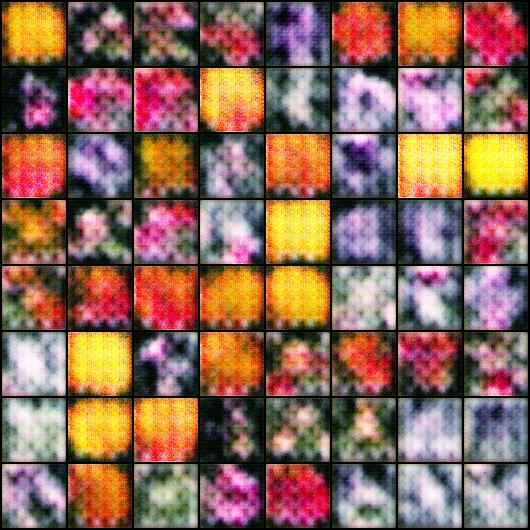

In [30]:
from IPython.display import Image, display_jpeg

display_jpeg(Image('/content/oxford-102/000.jpg'))